# Imports

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Filter corrupt images
Corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header

In [55]:
import os

num_skipped = 0
DATADIR = "C:/Users/Home/Documents/Semester 3/Data Mining & Machine Learning 2/Project/ArtImages"
CATEGORIES = ["Albrecht_Dürer","Alfred_Sisley","Amedeo_Modigliani","Andrei_Rublev","Andy_Warhol","Camille_Pissarro","Caravaggio",
             "Claude_Monet","Diego_Rivera","Diego_Velazquez","Edgar_Degas","Edouard_Manet","Edvard_Munch","El_Greco","Francisco_Goya",
              "Frida_Kahlo","Georges_Seurat","Gustav_Klimt","Gustave_Courbet","Henri_de_Toulouse-Lautrec",
              "Henri_Matisse","Henri_Rousseau","Hieronymus_Bosch","Jackson_Pollock","Jan_van_Eyck","Joan_Miro","Kazimir_Malevich",
             "Leonardo_da_Vinci","Marc_Chagall","Michelangelo","Mikhail_Vrubel","Pablo_Picasso","Pablo_Picasso","Paul_Cezanne",
             "Paul_Gauguin","Paul_Klee","Peter_Paul_Rubens","Pierre-Auguste_Renoir","Piet_Mondrian","Pieter_Bruegel","Raphael",
             "Rembrandt","Rene_Magritte","Salvador_Dali","Sandro_Botticelli","Titian","Vasiliy_Kandinskiy","Vincent_van_Gogh","William_Turner"]

for folder_name in CATEGORIES:
    folder_path = os.path.join(DATADIR, folder_name) # gets us into the path for Artists
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close
        
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            #os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 8733 images


# Generate a data set

In [56]:
image_size = (180,180)
batch_size = 32

DATADIR = "C:/Users/Home/Documents/Semester 3/Data Mining & Machine Learning 2/Project/ArtImages"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8446 files belonging to 49 classes.
Using 6757 files for training.
Found 8446 files belonging to 49 classes.
Using 1689 files for validation.


# Visualize the data

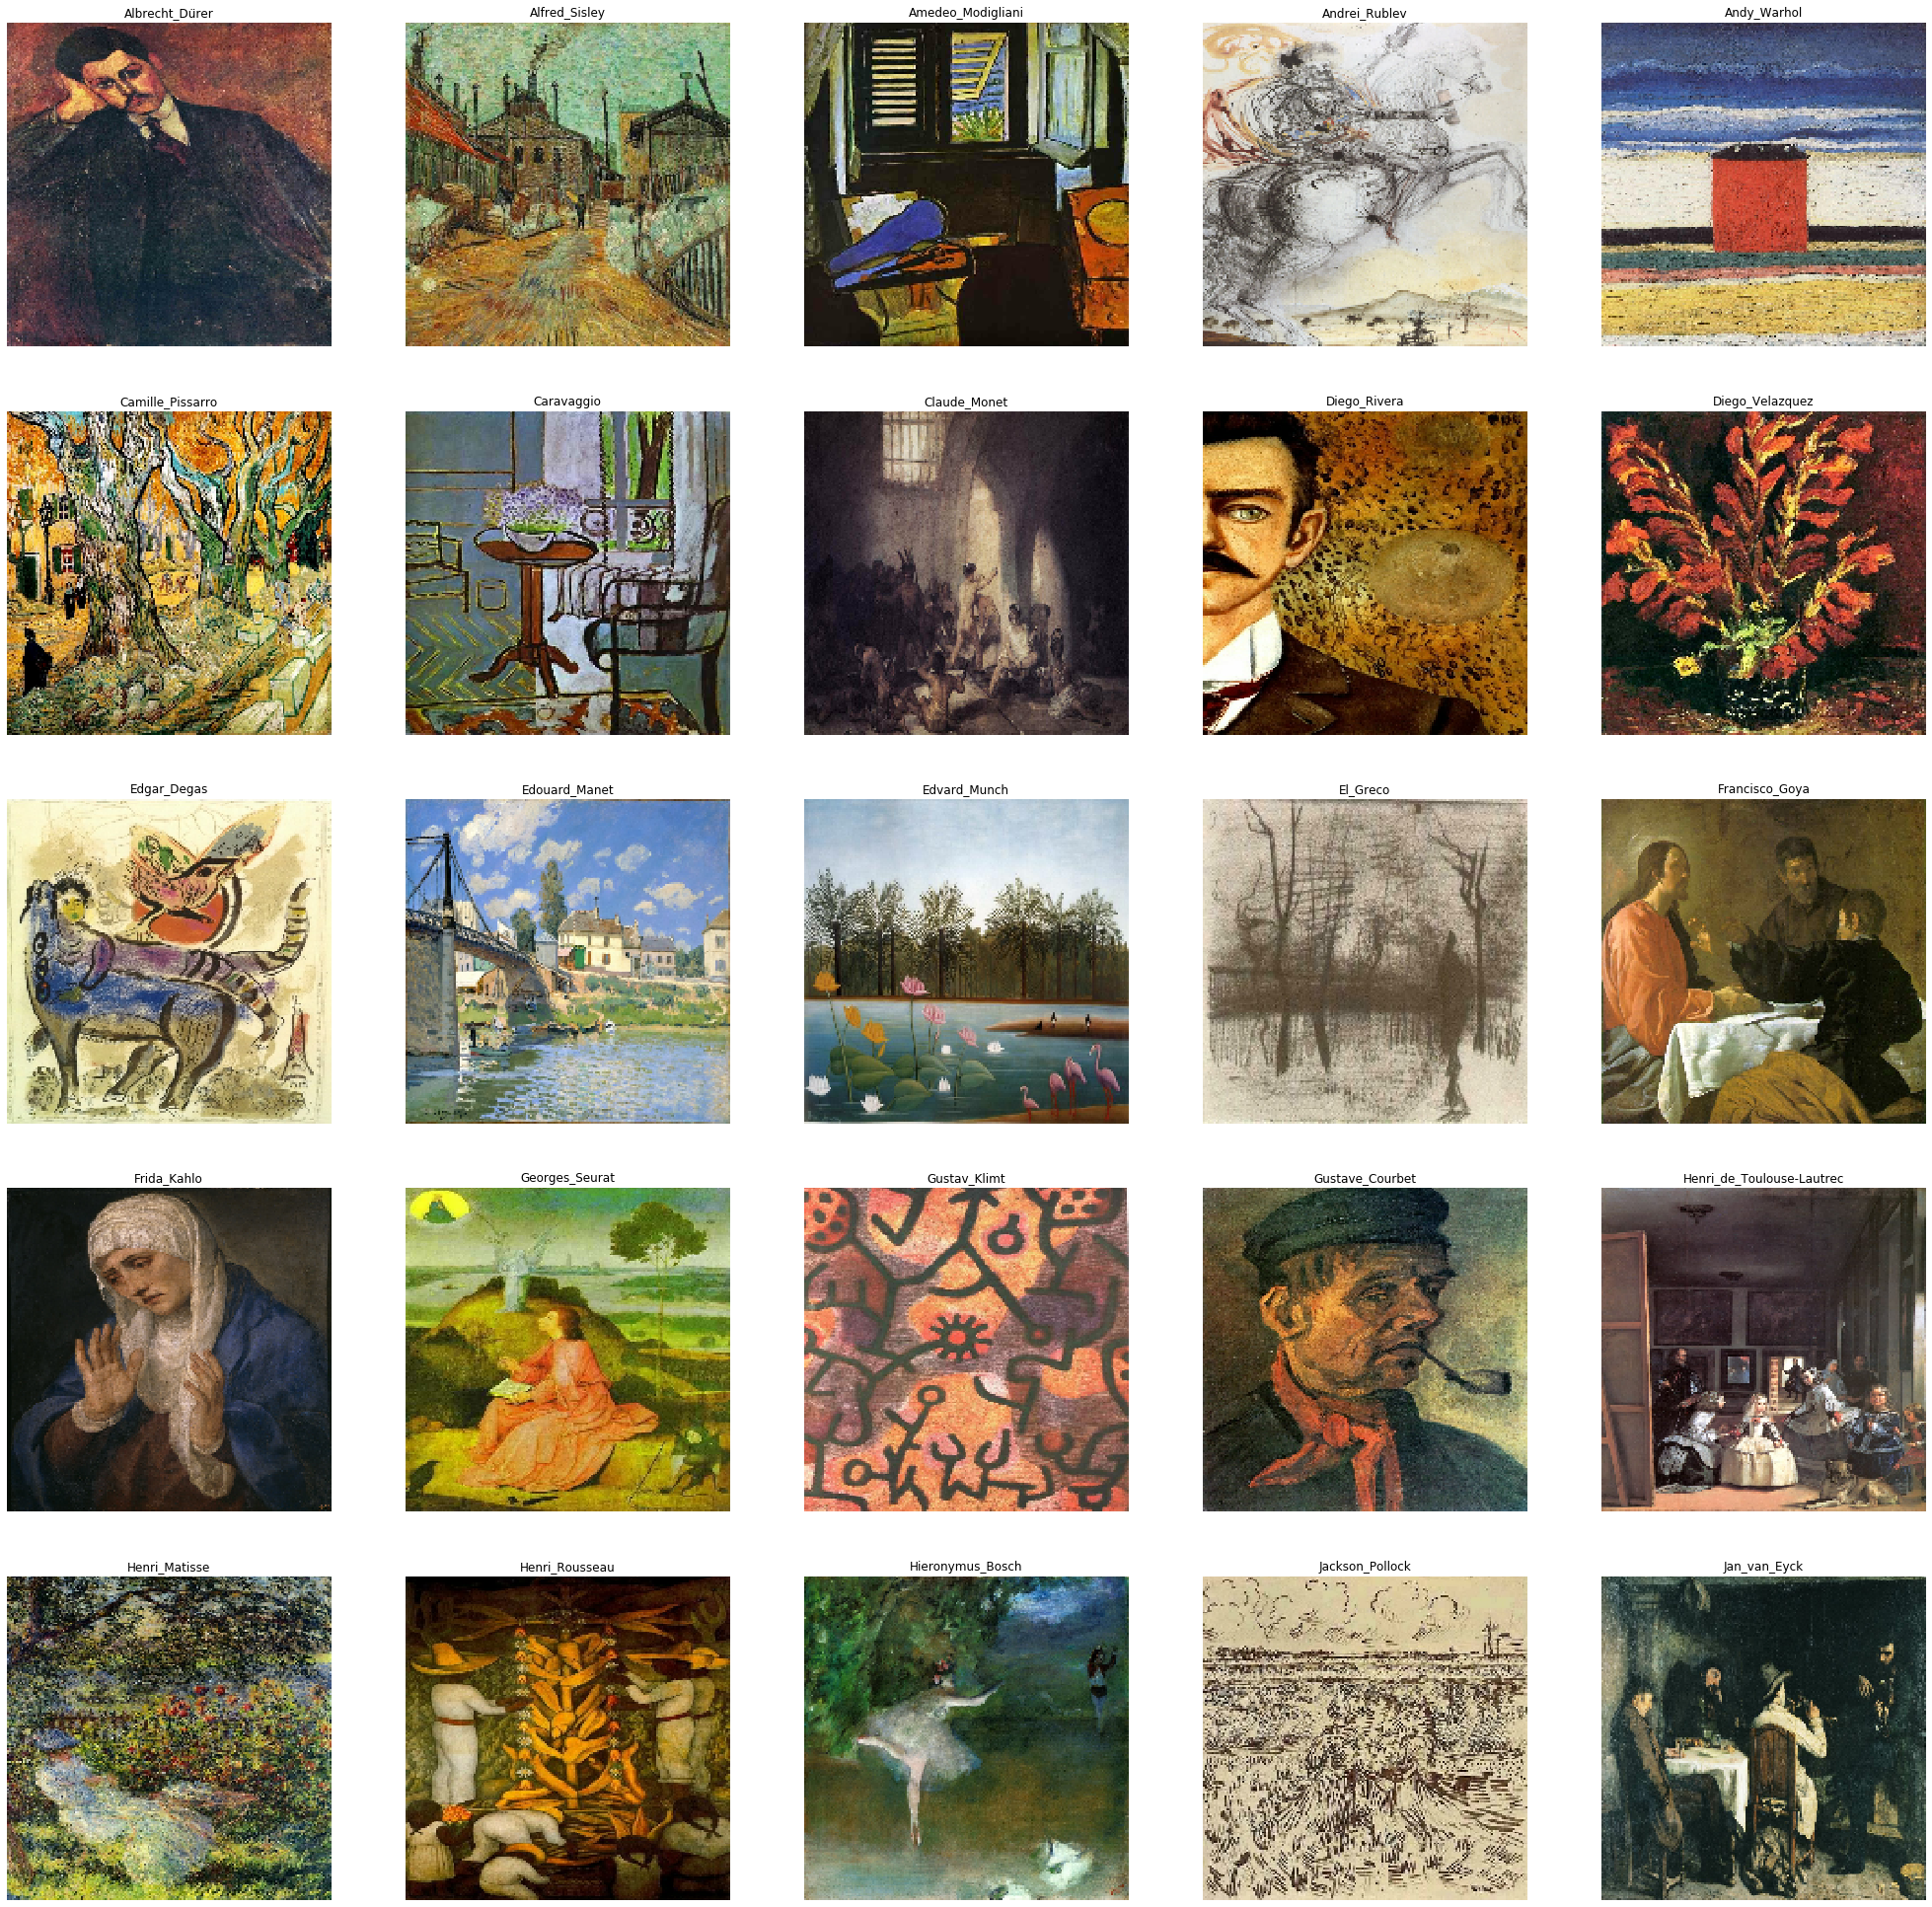

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(35,35))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CATEGORIES[i])
        plt.axis("off")

# Image augmentation
When you don't have a large image dataset, it's good practice to artificially introduce sample diversity
by applying random yet realistic transformations to the training images such as random horizontal flipping or small random rotations.
This helps expose the model to different aspects of the training data while slowing down overfitting

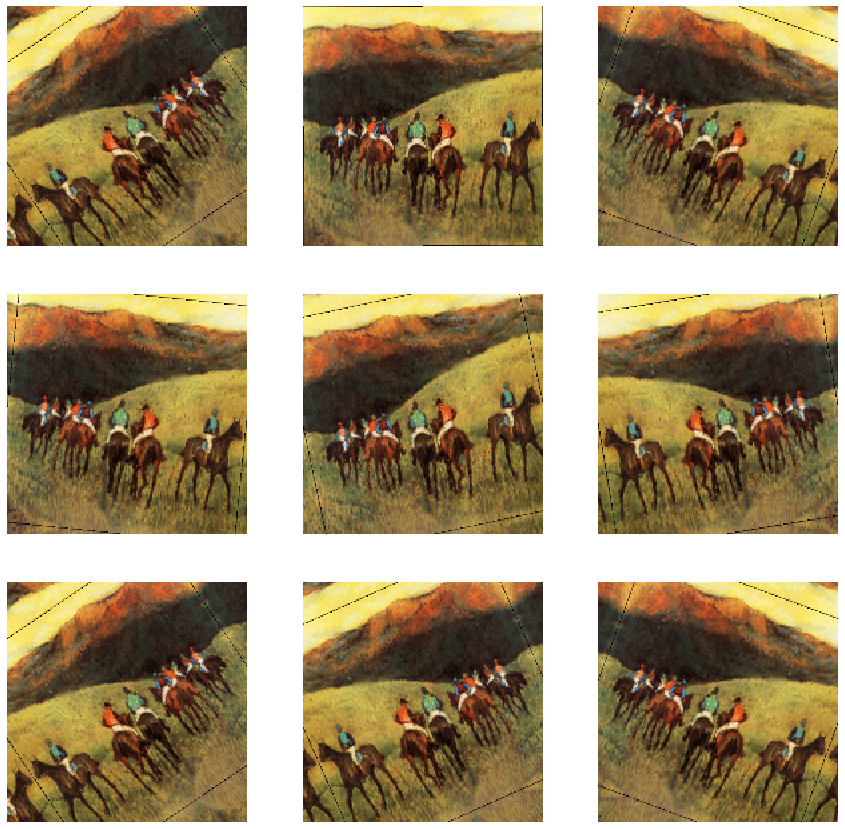

In [92]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly#
#to the first image in the dataset

plt.figure(figsize=(15,15))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

In [90]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Consider the data set for performance

In [71]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


# Build a model
We start the model with the data_augmentation preprocessor, followed by a Rescaling layer
We include a Dropout layer before the final classification layer

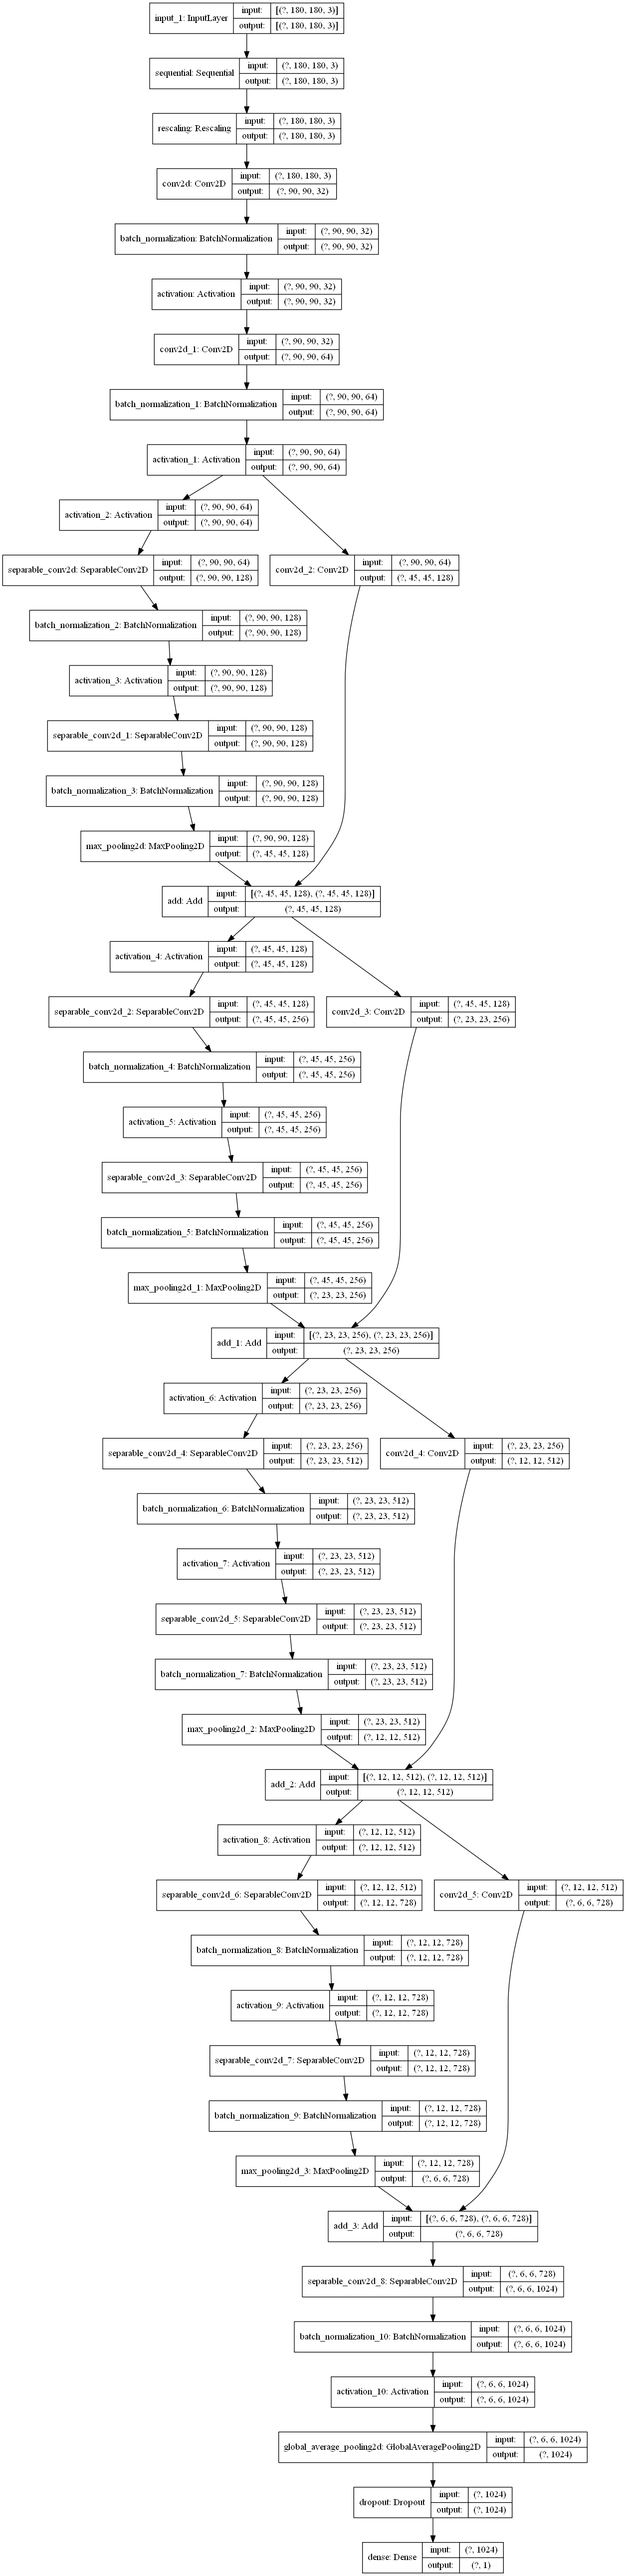

In [72]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 /255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) #Add back residual
        previous_block_activation = x #Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
        
model = make_model(input_shape=image_size + (3,), num_classes=2) #Where does image_size come from
keras.utils.plot_model(model, show_shapes=True)
   
    


# Train the model

In [73]:
#Train the model
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
212/212 [==============================] - 1337s 6s/step - loss: -1831.6858 - accuracy: 0.0332 - val_loss: -1317.0068 - val_accuracy: 0.0373
Epoch 2/5
212/212 [==============================] - 1320s 6s/step - loss: -9019.3857 - accuracy: 0.0290 - val_loss: -17026.2285 - val_accuracy: 0.0373
Epoch 3/5
212/212 [==============================] - 35192s 166s/step - loss: -22808.2207 - accuracy: 0.0290 - val_loss: -25007.5898 - val_accuracy: 0.0373
Epoch 4/5
212/212 [==============================] - 1392s 7s/step - loss: -43828.0430 - accuracy: 0.0290 - val_loss: -42571.1680 - val_accuracy: 0.0373
Epoch 5/5
212/212 [==============================] - 1360s 6s/step - loss: -70714.1719 - accuracy: 0.0290 - val_loss: -91433.3203 - val_accuracy: 0.0373


In [ ]:
[]